# Autumn School 2025: Exercise on RNA velocity

## Objectives

In this notebook, we will explore methods to infere progression of cells using RNA velocity and pseudotime. We will explore how both methods work and how they can be used to infer progression of cells along a trajectory. We will also compare the two methods and discuss their advantages and disadvantages.

For more in depth information, visit their respective documentation pages:
- [scVelo documentation](https://scvelo.readthedocs.io/en/stable)
- [Scanpy documentation](https://scanpy.readthedocs.io/en/stable)

## Setup

Before you run this Notebook, use the terminal to set it up. In the terminal in the folder where you saved this notebook, run this:

1. ```bash
   python -m venv venvVelocity
   ```

2. ```bash
   pip install scanpy scvelo igraph tqdm ipywidgets fa2-modified scikit-misc notebook ipykernel
   ```

3. ```bash
   python -m ipykernel install --user --name venvVelocity --display-name "Python (venvVelocity)"
   ```


If `2.` doesn't work and you have a windows laptop and

...use the terminal, try adding `python -m`

...use the Windows launcher, try adding `py -m`

before the pip install.

In [ ]:
!pip install scanpy scvelo igraph tqdm ipywidgets fa2-modified scikit-misc notebook ipykernel

# Data Preparation

Before we begin, we need to import the packages and data. We use an already clustered dataset two avoid having to start from scratch.

In [1]:
# Imports
import scvelo as scv
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
scv.settings.verbosity = 0  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

In [3]:
adata = scv.datasets.pancreas()

### ✏️ Exercise 1: Explore the Dataset
Take a look at the `adata` object that was just loaded. Answer:
- What kind of information is stored in `adata.obs`?
- How many cells and genes are in this dataset?

👉 Try using commands like `adata.obs.head()` or `adata.shape`.

We visualize the splicing proportions. As the RNA velocity is based on both spliced and unspliced, it is important to get an overview, not just of the overall proportions but also the proportions in each cluster:

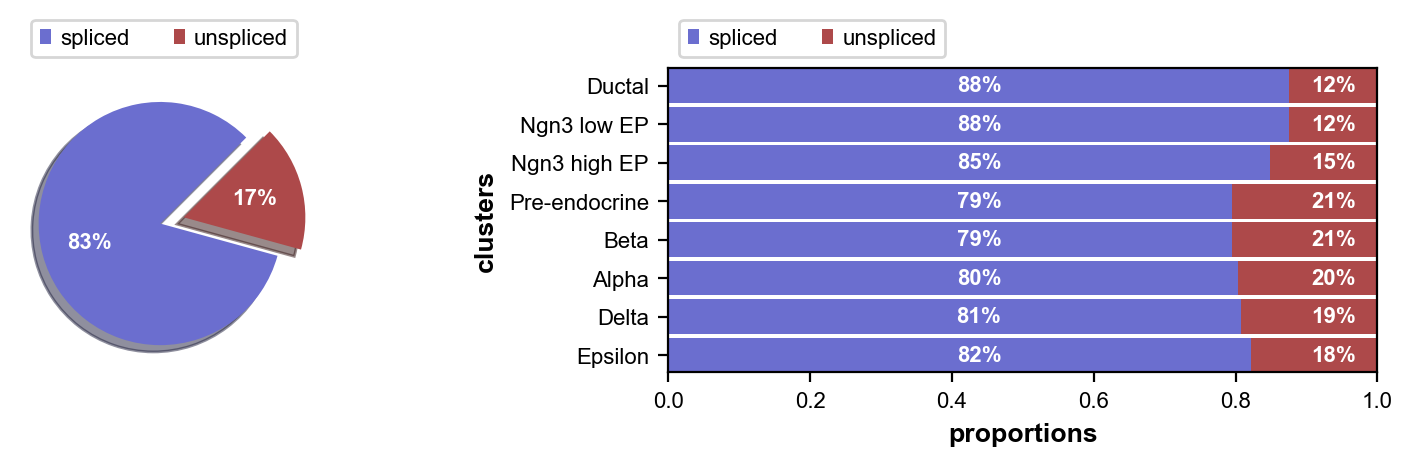

In [4]:
# Proportions of spliced and unspliced mRNA.
## Needs clusters in case of dataset change
ax = scv.pl.proportions(adata)

### ✏️ Exercise 2: Inspect Splicing Proportions
The plot above shows the ratio of spliced vs. unspliced mRNA.

- The pre-endocrine cluster shows high levels of unspliced RNA. What does this indicate w.r.t. transcription?

## Preprocessing & Filtering
Normalization/log‑transform and highly variable gene (HVG) selection shape the signal used for embeddings and velocity moments. For velocity, `scv.pp.filter_and_normalize` also handles gene/cell filtering tailored to splicing layers.
In detail, it does the following steps (which if desired can be run individually):

1. Filter Genes: keep genes that have at least `min_shared_counts` counts in spliced and unspliced ([documentation](https://scvelo.readthedocs.io/en/stable/scvelo.pp.filter_genes.html#scvelo-pp-filter-genes))
2. Normalize Per Cell: normalize each cell by total counts over all genes ([documentation](https://scvelo.readthedocs.io/en/stable/scvelo.pp.normalize_per_cell.html#scvelo.pp.normalize_per_cell))
3. Gene Dispersion: extract the `n_top_genes` most highly variable genes in terms of dispersion. As an intuition, dispersion is the variance divided by the mean. ([documentation](https://scvelo.readthedocs.io/en/stable/scvelo.pp.filter_genes_dispersion.html#scvelo.pp.filter_genes_dispersion))

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
# computing neighbors with scanPy
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

/Users/pauljonasjost/Documents/GitHub_Folders/AutumnSchool/venvTestScratch/lib/python3.12/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
sc.tl.draw_graph(adata)

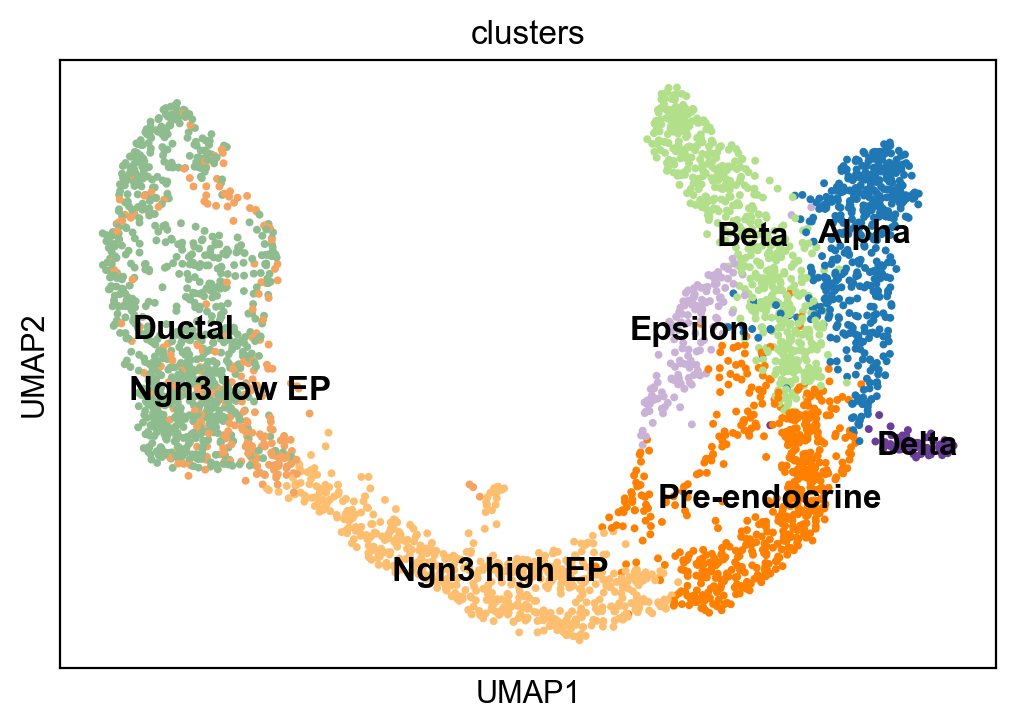

In [7]:
sc.pl.umap(adata, color="clusters", legend_loc="on data")

## Velocity Estimation using scVelo

## RNA Velocity Estimation
Moments are computed per cell based on the neighbor graph; models (stochastic/dynamical) relate spliced and unspliced counts to infer transcriptional dynamics. We then build a velocity graph encoding local transition tendencies.

In [8]:
# Get the RNA velocity estimates.
scv.tl.velocity(adata)

/Users/pauljonasjost/Documents/GitHub_Folders/AutumnSchool/venvTestScratch/lib/python3.12/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


In [9]:
scv.tl.velocity_graph(adata)

  0%|          | 0/3696 [00:00<?, ?cells/s]

/Users/pauljonasjost/Documents/GitHub_Folders/AutumnSchool/venvTestScratch/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pauljonasjost/Documents/GitHub_Folders/AutumnSchool/venvTestScratch/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pauljonasjost/Documents/GitHub_Folders/AutumnSchool/venvTestScratch/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isi

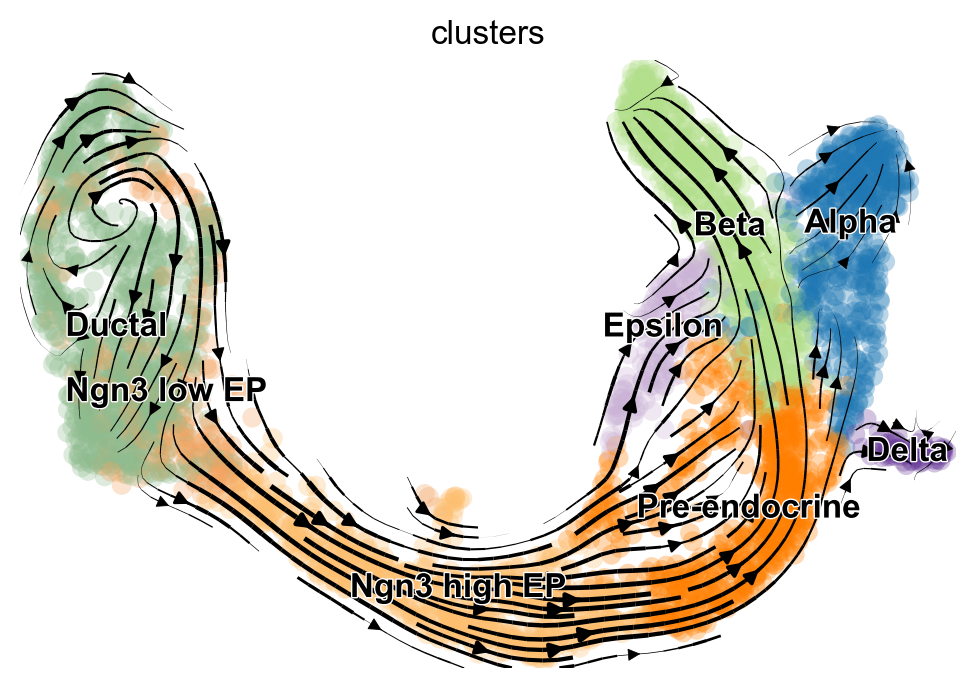

In [10]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

We can visualize specific genes showing changes in their spliced vs unspliced ratios:

/Users/pauljonasjost/Documents/GitHub_Folders/AutumnSchool/venvTestScratch/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pauljonasjost/Documents/GitHub_Folders/AutumnSchool/venvTestScratch/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pauljonasjost/Documents/GitHub_Folders/AutumnSchool/venvTestScratch/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isi

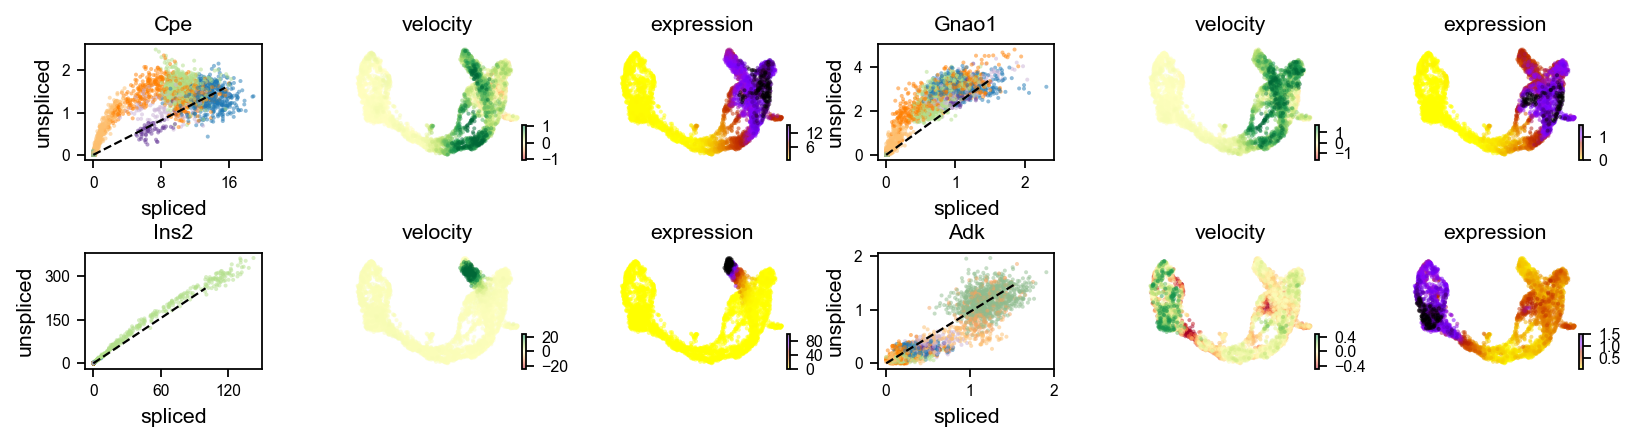

In [11]:
scv.pl.velocity(adata, ['Cpe',  'Gnao1', 'Ins2', 'Adk'], ncols=2)

In order to find genes, whose velocity patterns are significantly different among the clusters, we can use `rank_velocity_genes` ([documentation](https://scvelo.readthedocs.io/en/stable/scvelo.tl.rank_velocity_genes.html#scvelo.tl.rank_velocity_genes)).
In this we group cells with the `groupby` argument and run a differential expression test. We find genes that have significantly different behaviour in one cluster compared to all other clusters. We can visualize the spliced/unspliced ratio of these genes.

In [12]:
# Identify key genes that drive the velocity dynamics.
scv.tl.rank_velocity_genes(adata, groupby='clusters', min_corr=.5) # Maybe provide some intuition how this is done?

df = pd.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

/Users/pauljonasjost/Documents/GitHub_Folders/AutumnSchool/venvTestScratch/lib/python3.12/site-packages/scvelo/tools/utils.py:463: DeprecationWarning: Please import `rankdata` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import rankdata


Ductal Ngn3 low EP Ngn3 high EP Pre-endocrine     Beta    Alpha    Delta  \
0  Notch2       Hacd1        Pde1c           Pam     Pax6  Zcchc16    Zdbf2   
1    Sox5       Hspa8         Pclo          Sdk1    Unc5c    Nlgn1  Akr1c19   
2   Krt19      Gm8113     Rap1gap2        Baiap3     Nnat    Nell1    Ptprt   
3   Hspa8       Kcnq1        Ttyh2         Abcc8  Tmem108   Prune2   Snap25   
4    Ano6     Stard10        Kcnb2          Gnas    Ptprt     Ksr2      Cpm   

  Epsilon  
0   Tmcc3  
1    Heg1  
2  Gpr179  
3    Ica1  
4   Ncoa7

/Users/pauljonasjost/Documents/GitHub_Folders/AutumnSchool/venvTestScratch/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pauljonasjost/Documents/GitHub_Folders/AutumnSchool/venvTestScratch/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pauljonasjost/Documents/GitHub_Folders/AutumnSchool/venvTestScratch/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isi

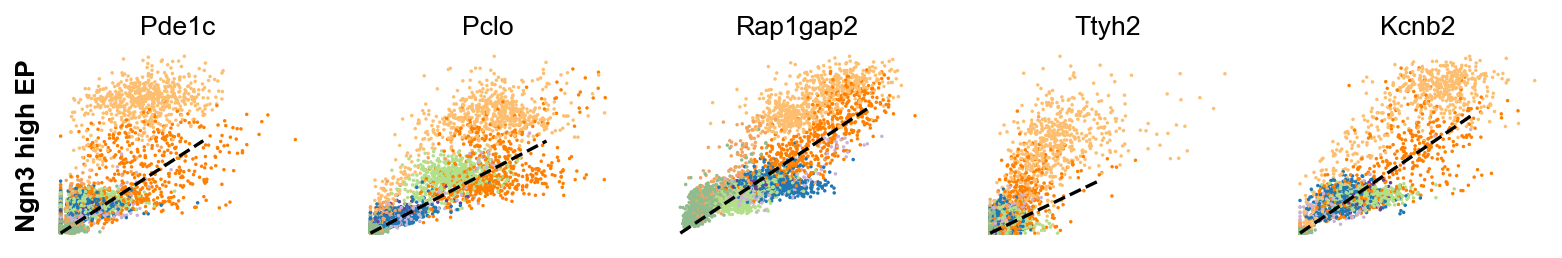

/Users/pauljonasjost/Documents/GitHub_Folders/AutumnSchool/venvTestScratch/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pauljonasjost/Documents/GitHub_Folders/AutumnSchool/venvTestScratch/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pauljonasjost/Documents/GitHub_Folders/AutumnSchool/venvTestScratch/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isi

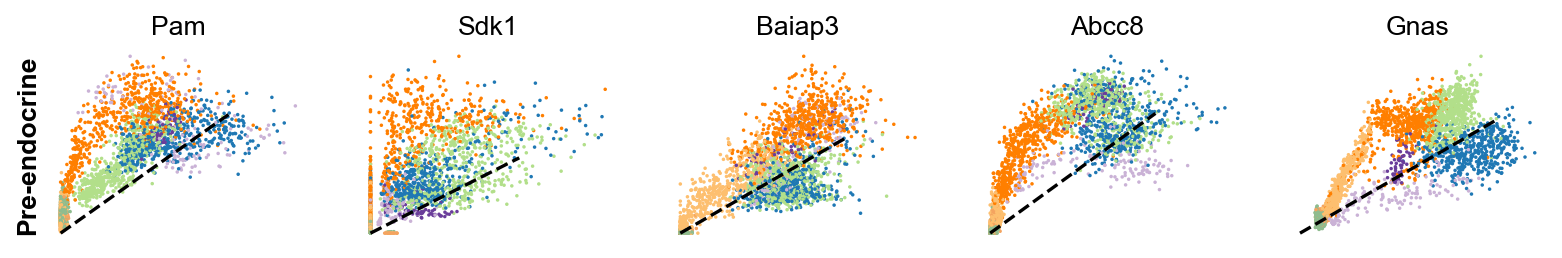

In [13]:
# Visualization on clusters.
kwargs = dict(frameon=False, size=10, linewidth=1.5)

scv.pl.scatter(adata, df['Ngn3 high EP'][:5], ylabel='Ngn3 high EP', **kwargs)
scv.pl.scatter(adata, df['Pre-endocrine'][:5], ylabel='Pre-endocrine', **kwargs)

/Users/pauljonasjost/Documents/GitHub_Folders/AutumnSchool/venvTestScratch/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pauljonasjost/Documents/GitHub_Folders/AutumnSchool/venvTestScratch/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/pauljonasjost/Documents/GitHub_Folders/AutumnSchool/venvTestScratch/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isi

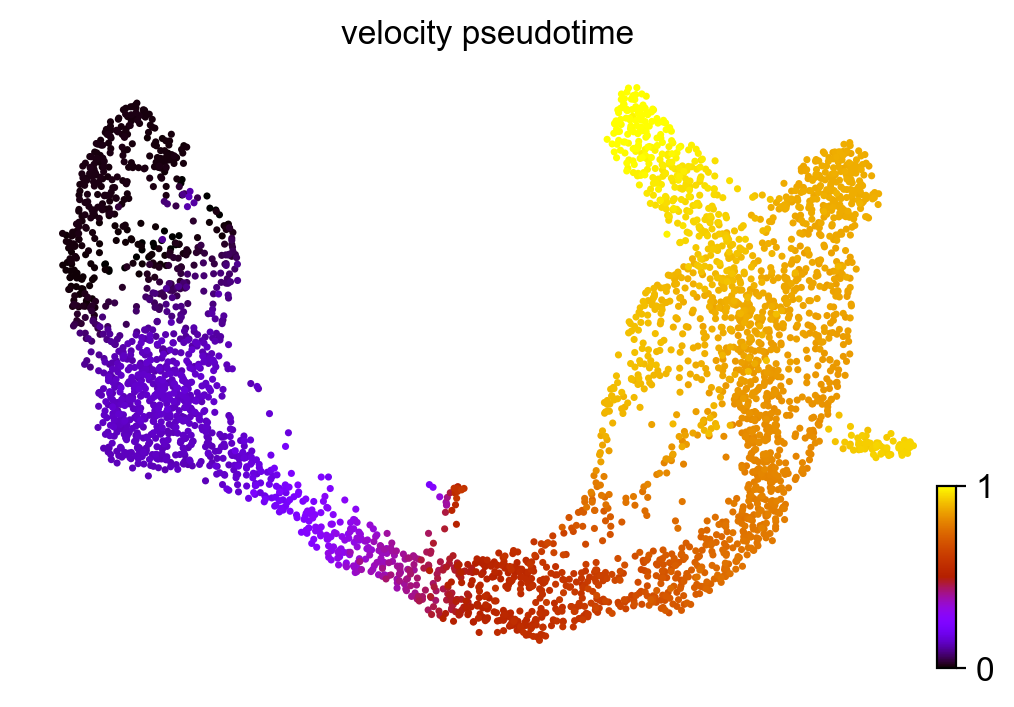

In [14]:
# Velocity Pseudotime
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

### ✏️ Exercise 3: Exploring Velocities

- It is your turn to explore RNA velocities. Pick out your favorite gene (or any of your choice) and visualize its velocity and expression. Is it aligned with the pseudotime?

## Diffusion Pseudotime

In many cases we might not have spliced and unspliced gene ratios. To still estimate progressions throughout datasets, one can use diffusion pseudotime (DPT). DPT computes diffusion-based similarities between cells and, from a chosen starting cell, derives a virtual ordering of cells along probable trajectories [[Haghverdi et al., 2016](https://doi.org/10.1038/nmeth.3971)].

### Diffusion Pseudotime vs. RNA Velocity: What and Why

**Diffusion Pseudotime (concept):** Orders cells along a presumed progression using *current* transcriptomic similarity. It assumes gradual, monotonic changes between states. The output is a **relative ordering** (a scalar per cell), not absolute time. It is sensitive to trajectory choice, branching, and root selection.

**RNA Velocity (concept):** Estimates a cell’s **near‑future transcriptional direction** by modeling ratios of **spliced vs. unspliced** transcripts (or analogous kinetics). The output is a **vector field** on the embedding that can indicate flows toward fate decisions. It depends on modeling assumptions and data quality (depth, capture of unspliced reads).

**Core differences:** Pseudotime yields a 1D ordering without inherent directionality; RNA velocity provides directed transitions over short time scales. Pseudotime is broadly applicable without splicing layers; velocity offers mechanistic direction but requires reliable splicing quantification and appropriate modeling.

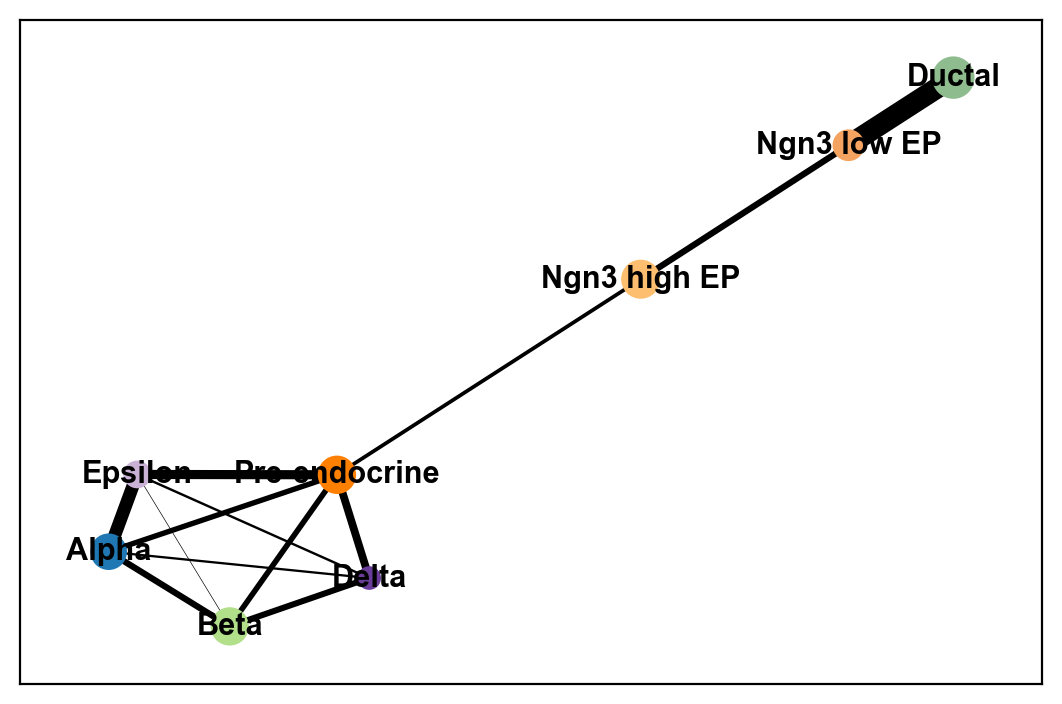

In [15]:
# PAGA = partition based graph abstraction
# Through this function we build a representation of the data, quantifying the connectivity of the different clusters.
sc.tl.paga(adata, groups="clusters")
sc.pl.paga(adata, color=["clusters"])

In [16]:
# Set a root/start point for the DPT and calculate DPT
adata.uns["iroot"] = np.flatnonzero(adata.obs["clusters"] == "Ductal")[0]
sc.tl.dpt(adata)

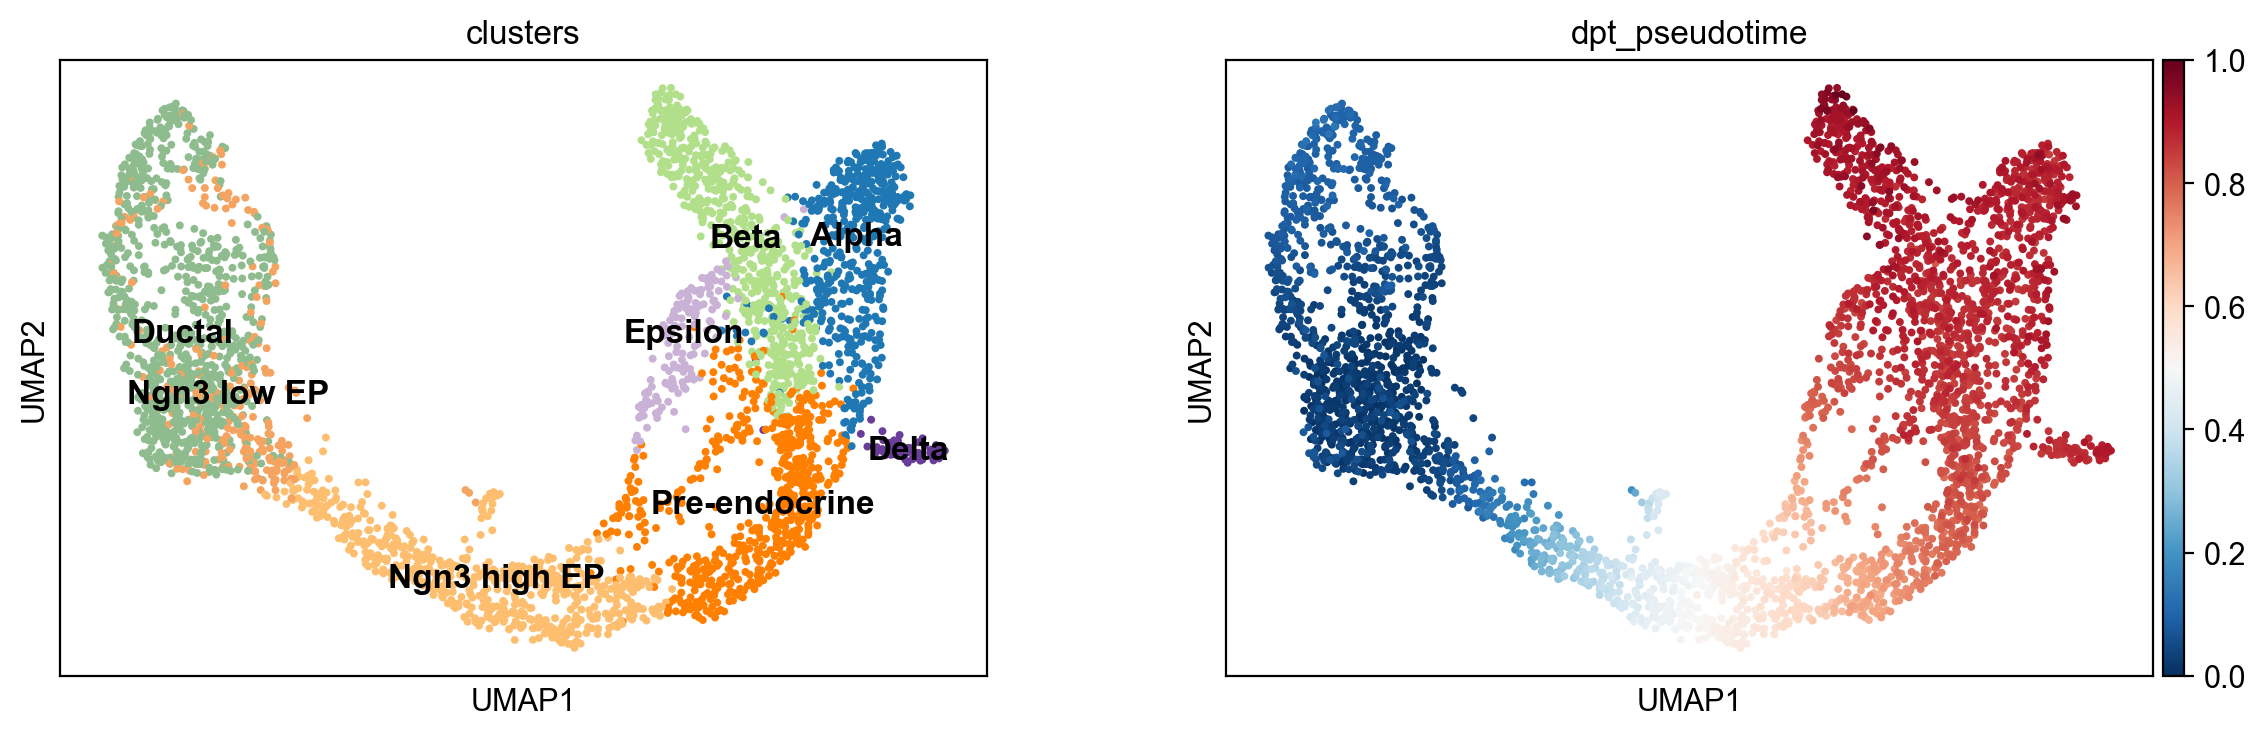

In [17]:
sc.pl.umap(
    adata, color=["clusters", "dpt_pseudotime"], legend_loc="on data"
)

Along the Pseudotime, we want to see how the expression of genes changes. For this we decide on a path (i.e. a sequence of clusters) and visualize the expression along that path. We also define the genes we would like to take a look at, a good choice for this are either known marker genes or differentially expressed genes we have found in previous sessions.

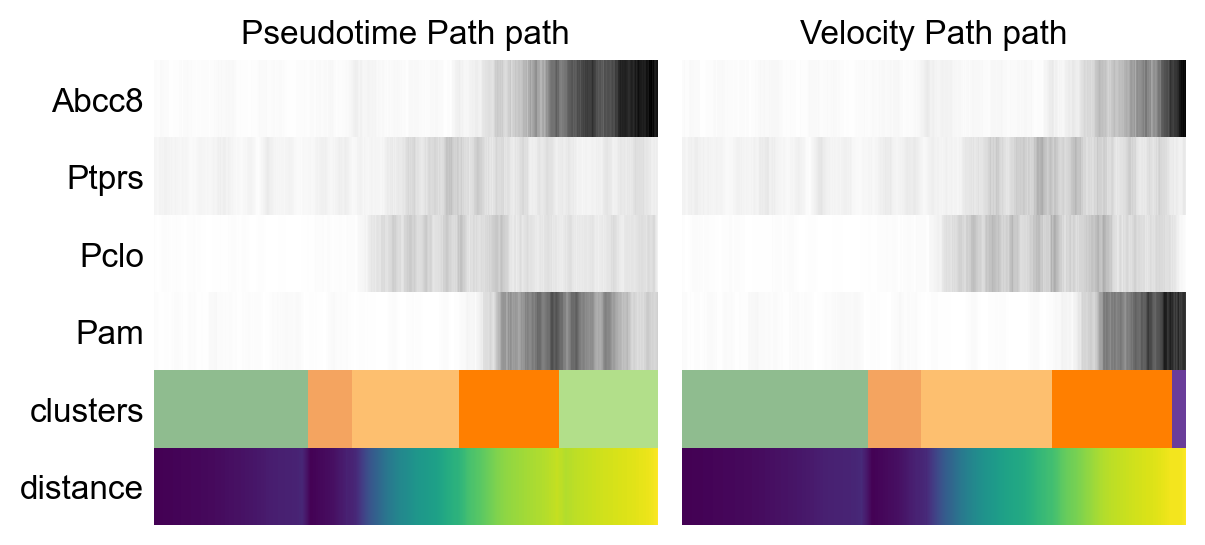

In [18]:
# Find own Paths and Genes
paths = [
    ("Pseudotime Path", ["Ductal", "Ngn3 low EP", "Ngn3 high EP", "Pre-endocrine", "Beta"]),
    ("Velocity Path", ["Ductal", "Ngn3 low EP", "Ngn3 high EP", "Pre-endocrine", "Delta"]),
]
gene_names = ["Abcc8", "Ptprs", "Pclo", "Pam"]
adata.obs["distance"] = adata.obs["dpt_pseudotime"]
_, axs = plt.subplots(
    ncols=2, figsize=(6, 2.5), gridspec_kw={"wspace": 0.05, "left": 0.12}
)
plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    data = sc.pl.paga_path(
        adata,
        path,
        gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=["distance"],
        show_yticks=True if ipath == 0 else False,
        show_colorbar=False,
        color_map="Greys",
        groups_key="clusters",
        color_maps_annotations={"distance": "viridis"},
        title="{} path".format(descr),
        return_data=True,
        show=False,
    )
plt.show()

### ✏️ Exercise 4: Diffusion Pseudotime
- We have set the root for the Pseudotime. What happens if we change the root? Is there an optimal starting point?
- Why did we choose the paths in the Pseudotime? Can you think of other possible Paths? How would you interpret the results?

## Comparison of Pseudotime and RNA Velocity

Both pseudotime and rna velocity can be used to order cells along a trajectory, but they do so in different ways. Diffusion based pseudotime orders cells based on their current state, while RNA velocity predicts the future state of cells based on their current transcriptional dynamics. Naturally the question arises whether these two methods yield similar results. We can compare the two methods by visualizing the pseudotime and velocity pseudotime on the same UMAP embedding.

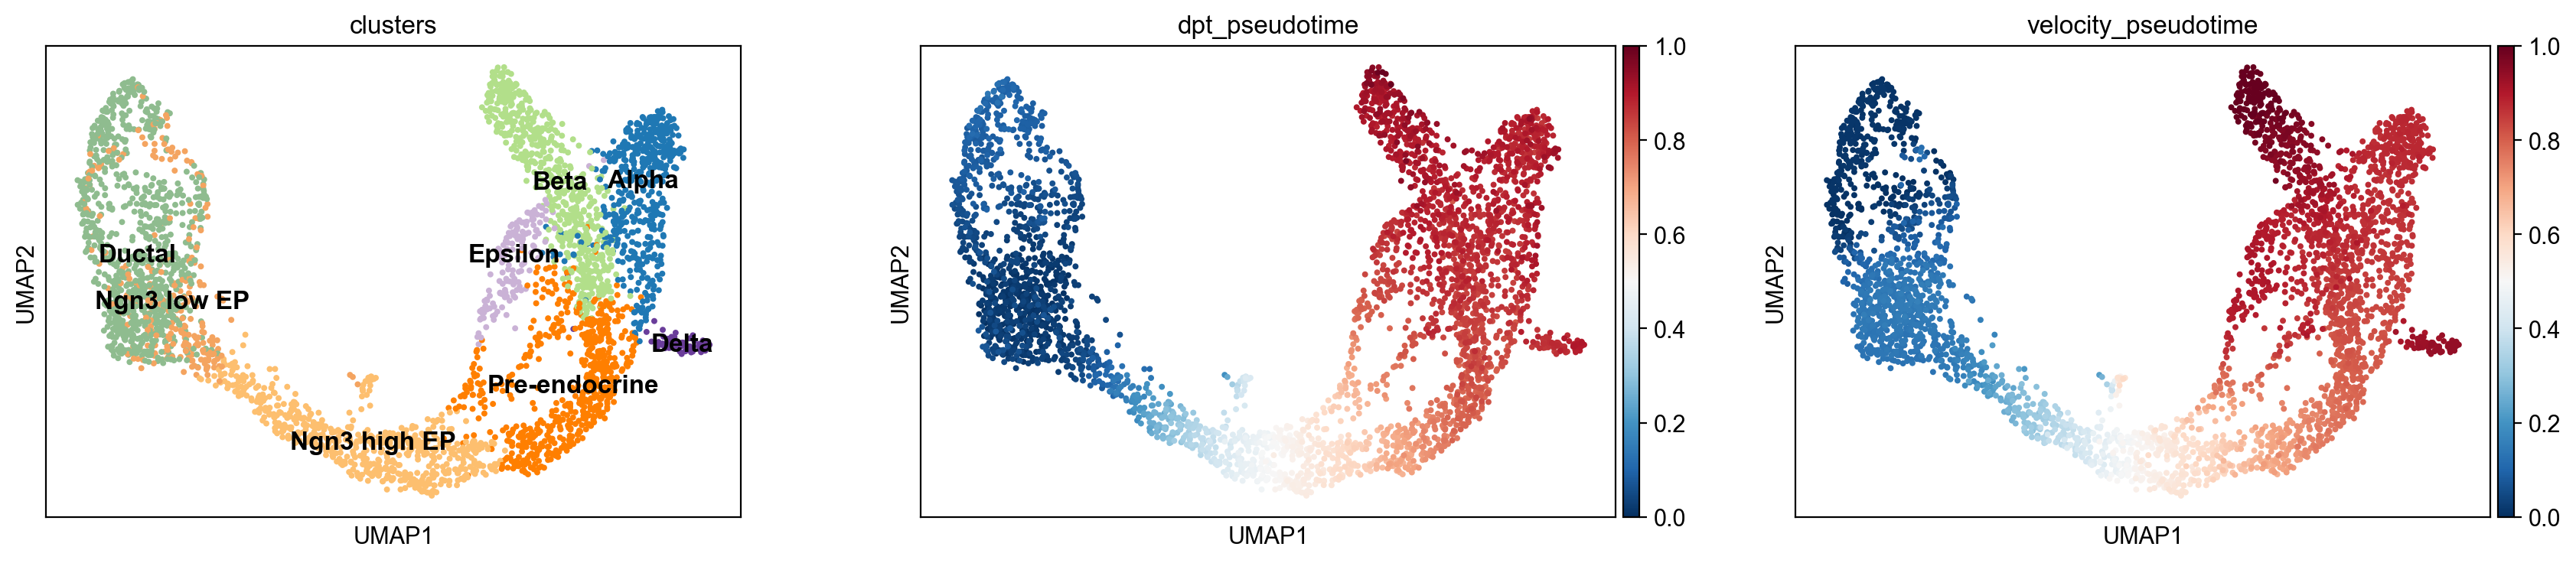

In [19]:
sc.pl.umap(
    adata, color=["clusters", "dpt_pseudotime", "velocity_pseudotime"], legend_loc="on data"
)

We can also redraw the UMAP based on the PAGA graph computation: *What actually does PAGA stands for?

In [20]:
# redraw graph based on paga
sc.tl.umap(adata, init_pos="paga", key_added="umap_paga")

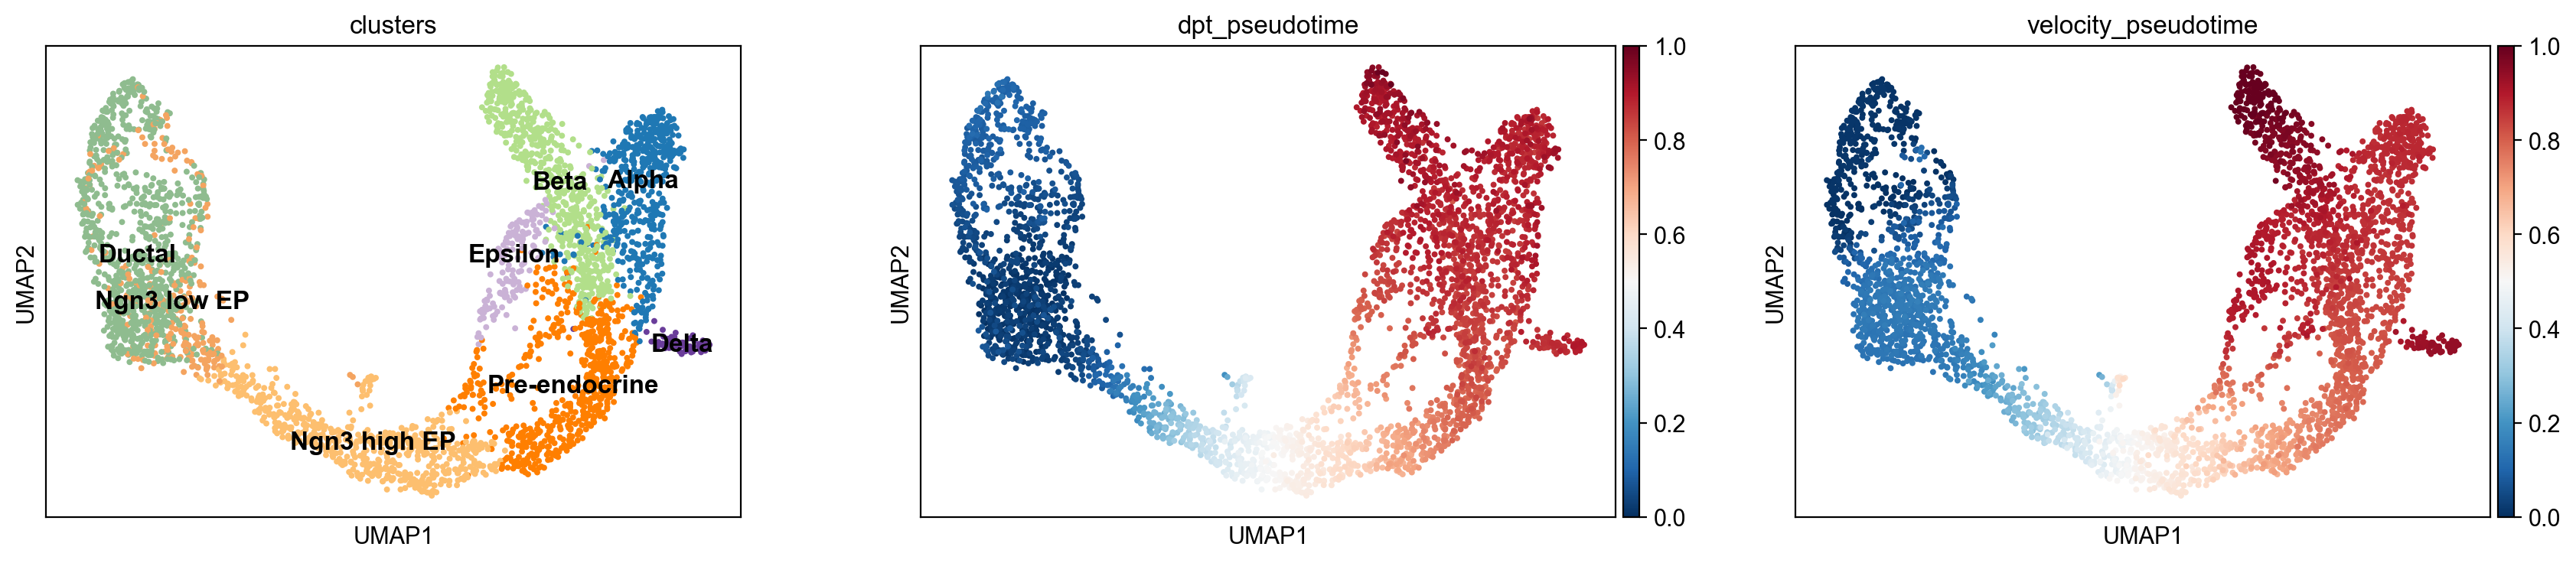

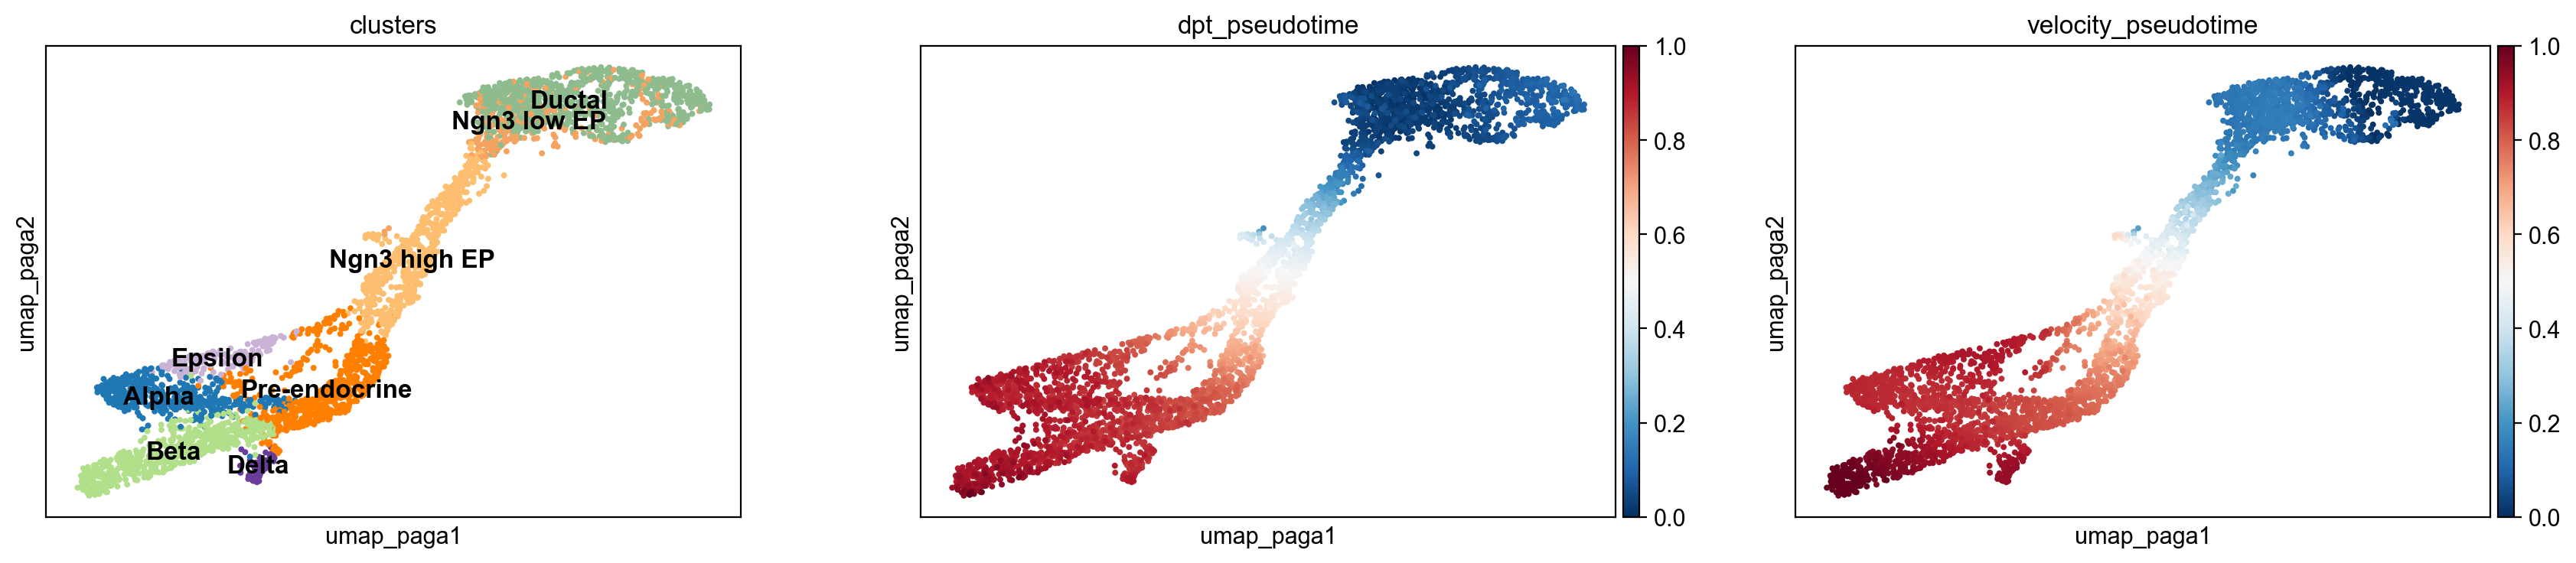

In [21]:
sc.pl.embedding(adata, basis="umap", color=["clusters", "dpt_pseudotime", "velocity_pseudotime"], legend_loc="on data")
sc.pl.embedding(adata, basis="umap_paga", color=["clusters", "dpt_pseudotime", "velocity_pseudotime"], legend_loc="on data")

### ✏️ Exercise 5: Comparison of Pseudotime Inference Methods
- What are the differences in the two pseudotimes? Discuss differences in the methods as well as up and downsides of the two methods
- When is which method preferable? Give an example scenario for each
- What could be common pitfalls when interpreting the results?
- Compare the the two UMAP representations (with/without PAGA adjustment). Where do these differences come from? Is there a correct representation?

## 🔄 Adapting the Notebook to Other Datasets

This notebook currently uses the built-in pancreas dataset from `scv.datasets`. To adapt it:

1. **Load a different dataset:**
   ```python
   adata = scv.datasets.dentategyrus()
   ```
   Or load your own `.h5ad` file:
   ```python
   adata = sc.read_h5ad('my_dataset.h5ad')
   ```

2. **Check that spliced/unspliced layers exist:**
   Velocity analysis requires `adata.layers['spliced']` and `adata.layers['unspliced']`.
   If missing, you need to generate them from raw sequencing data.

3. **Update metadata fields:**
   - Some plots assume clusters are stored in `adata.obs['clusters']`. If your dataset uses a different column (e.g., `cell_type`), update the plotting functions accordingly.

4. **Tune preprocessing parameters:**
   - Adjust `n_top_genes`, `n_neighbors`, and `n_pcs` depending on dataset size and complexity.

👉 By following these steps, you can reuse this notebook for a wide range of single-cell datasets. In case something does not work, use chatGPT or other language models to assis you in the code generation.